In [ ]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import combinations
from sklearn import linear_model, metrics, model_selection
import statsmodels.api as sm
import pickle

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Aquisition and Cleaning


In [ ]:
#get json file from voteview.com
rolls = pd.read_json("https://voteview.com/static/data/out/rollcalls/HSall_rollcalls.json")

In [ ]:
#copying our dataframe
roll = rolls.copy()
n = roll['issue_codes']

#chaging datatypes of columns
roll['date'] = pd.to_datetime(rolls['date'])

#deal with null values 
values = {'bill_number': '', 'vote_result':'', 
          "vote_desc":'', "vote_question":'', 'dtl_desc':""}
roll.fillna(values, inplace = True)

#dealing with clausen codes
roll['clausen_codes'] = np.array([i[0] if i else None for i in rolls['clausen_codes']])
roll[roll['clausen_codes'].isna()][['clausen_codes']].sample(30)
cc = pd.get_dummies(roll[['clausen_codes']], dummy_na=True)

#dealing with issue codes
roll['issue_codes']= [str(i).strip('[]') if i else None for i in roll['issue_codes']]
iss = roll['issue_codes'].str.get_dummies(sep=',')

#dealing with peltzman codes
roll['peltzman_codes']= [str(i).strip('[]') if i else None for i in roll['peltzman_codes']]
peltz = roll['peltzman_codes'].str.get_dummies(sep=',')
roll = pd.concat((roll, cc, iss, peltz), axis=1)

#removing uneccesary columns

roll.drop(columns=["clerk_rollnumber","session",'clausen_codes','issue_codes','congress_url','peltzman_codes'],inplace=True)


#adding the column of percent in favor of the bill
roll['percent_yea'] = roll["yea_count"]/(roll['yea_count']+roll['nay_count'])
roll[['yea_count','nay_count','percent_yea']].sample(10)
roll.head()

,bill_number,chamber,congress,crs_policy_area,crs_subjects,date,dtl_desc,nay_count,nominate_log_likelihood,nominate_mid_1,...,'Defense Policy Resolutions','Domestic Social Policy','Foreign Policy Budget','Foreign Policy Resolutions','Government Organization','Indian Affairs','Internal Organization','Regulation General Interest','Regulation Special Interest',percent_yea
0,HR2,House,1,None,None,1789-05-16,"TO AMEND H.R. 2, (1 STAT. 24, APP. 7-4-1789), ...",8,-13.144,0.484,...,0,0,0,0,0,0,0,1,0,0.836735
1,,House,1,None,None,1789-05-22,TO PASS THE RESOLUTION THAT IT APPEARS TO THIS...,1,-1.900,0.256,...,0,0,0,0,0,0,1,0,0,0.972973
2,HR8,House,1,None,None,1789-06-22,"TO AMEND H.R. 8, (1 STAT. 28, APP. 7-27-1789),...",18,-22.048,-0.394,...,0,0,0,0,1,0,0,0,0,0.625000
3,HR8,House,1,None,None,1789-06-22,"TO AMEND H.R. 8, SO AS TO ELIMINATE THE PRESID...",19,-30.355,-0.194,...,0,0,0,0,1,0,0,0,0,0.620000
4,HR8,House,1,None,None,1789-06-24,TO PASS H.R. 8.,22,-22.221,-0.197,...,0,0,0,0,1,0,0,0,0,0.568627


In [ ]:
#member ideology 
ideas = pd.read_json("https://voteview.com/static/data/out/members/HSall_members.json")


In [ ]:
#copy the dataframe
idea = ideas.copy()

#drop uneccessary columns
idea.drop(columns=["state_icpsr",'district_code','occupancy','last_means'],inplace=True)

idea = idea.astype({'icpsr': 'str', 'party_code':'str'})

#deal with null values
values = {'party_code': '', 'icpsr':"", 'bioguide_id':""}
idea.fillna(values, inplace = True)

In [ ]:
#code for getting the variance of political ideology as a measure of the polarization of congress
 
congress = idea.groupby('congress')
 
polarity_dim1 = []
polarity_dim2 = []
 
#for each congress that has been in session (this means every two years)
for n in idea.congress.unique():
 
    polarity_dim1.append(congress.get_group(n)['nominate_dim1'].var(axis=0))
    polarity_dim2.append(congress.get_group(n)['nominate_dim2'].var(axis=0))
#     stuff = congress.get_group(n)['nominate_dim1'].to_numpy()
 
 
#we can add this into one of our dataframe objects as needed
print(polarity_dim1[80])
print(polarity_dim2[93])



#here is code for the age in years when they were elected
 
#dictionary containing the year the congress started
years = np.linspace(1789, 2019, 116, endpoint=True)
years = np.hstack(([0], years))
idea['age_when_elected'] = years[idea['congress']] - idea['born'] 

#here is code for the average age of congress
 
average_age = []
variance_age = []
 
congress = idea.groupby('congress')
for n in idea.congress.unique():
    average_age.append(congress.get_group(n)['age_when_elected'].mean(axis=0))
    variance_age.append(congress.get_group(n)['age_when_elected'].var(axis=0))
 
print(average_age[10])
print(variance_age[11])


0.10240665594296935
0.22154390899268103
46.27807486631016
99.17757830644653


In [ ]:
#how individual members have voted on bills
mem_vote = pd.read_csv("https://voteview.com/static/data/out/votes/HSall_votes.csv") 

In [ ]:
mem_votes = mem_vote.copy()
mem_votes = mem_votes.astype({'icpsr': 'str'})

values = {'icpsr':""}
mem_votes.fillna(values, inplace = True)

In [ ]:
#this is to create a column of whether a person voted positively or 
#negatively or neutrally
#this motivates the scheme of 1, 0, and -1 so that when the sum is 
#computed, we can see where the majority voted, negative being against
#and positive being fore with no other computation needed
def voted_positive(x):
    if x in [1,2,3]:
        return 1
    elif x in [4,5,6]:
        return -1
    else:
        return 0
voted = np.vectorize(voted_positive)
mem_votes['yea_nay'] = voted(mem_votes.cast_code)
mem_votes.sample(10)

,congress,chamber,rollnumber,icpsr,cast_code,prob,yea_nay
21286061,111,House,471,29735,1,68.2,1
23778185,114,Senate,117,40705,6,100.0,-1
1290146,26,House,670,1539,6,52.3,-1
19739283,109,House,280,20506,6,99.8,-1
6274694,60,House,265,6638,1,NaN,1
8823570,82,Senate,51,10163,1,86.0,1
8403776,79,House,115,7731,1,87.5,1
443831,17,House,38,10042,1,53.6,1
17758532,105,House,912,29516,6,99.9,-1
8240751,77,House,138,1369,9,92.5,0


In [ ]:
oneohsix = mem_votes.loc[mem_votes.congress == 106]
oneohsix = oneohsix[['congress', 'rollnumber', 'icpsr', 'yea_nay']]
# print(oneohsix['congress'].unique())
# print(oneohsix['rollnumber'].unique())
# print(oneohsix['icpsr'].unique())
print('Number of bills: ', len(oneohsix['rollnumber'].unique()))
print('Number of congressmen: ',  len(oneohsix['icpsr'].unique()))

Number of bills:  1209
Number of congressmen:  543


In [ ]:
bills = len(oneohsix['rollnumber'].unique())
rollcalls = list(oneohsix['rollnumber'].unique())
congresspeople = len(oneohsix['icpsr'].unique())
icpsrs = list(oneohsix['icpsr'].unique())
oneohsix_votes = np.zeros((congresspeople, bills))

In [ ]:
for index, row in oneohsix.iterrows():
    oneohsix_votes[icpsrs.index(row['icpsr'])][rollcalls.index(row['rollnumber'])] = row['yea_nay']


In [ ]:
print(oneohsix_votes)

[[-1. -1.  1. ... -1. -1.  1.]
 [-1. -1.  1. ...  0.  0.  0.]
 [-1. -1.  1. ...  1. -1.  0.]
 ...
 [ 1. -1. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [ ]:
#get the labels for each of the rows
#labels here mean party
oneohsix_parties = np.zeros(congresspeople)
for i, icp in enumerate(icpsrs):
#     print(idea.loc[idea.icpsr == icp])
    oneohsix_parties[i] = idea.loc[idea.icpsr == icp].sample(1).party_code

oneohsix_parties

    

array([100., 100., 100., 100., 100., 100., 200., 200., 100., 200., 200.,
       200., 100., 200., 200., 100., 200., 100., 200., 100., 100., 100.,
       100., 200., 200., 100., 100., 100., 100., 200., 100., 100., 100.,
       200., 100., 200., 200., 100., 100., 100., 200., 100., 100., 200.,
       100., 200., 200., 200., 200., 100., 200., 100., 100., 100., 200.,
       200., 100., 200., 200., 200., 200., 200., 200., 200., 100., 200.,
       100., 100., 200., 100., 200., 200., 100., 100., 200., 100., 200.,
       200., 100., 200., 100., 100., 100., 100., 200., 100., 100., 100.,
       100., 100., 100., 200., 200., 200., 200., 200., 100., 100., 200.,
       200., 100., 100., 200., 100., 200., 200., 100., 100., 200., 200.,
       200., 200., 200., 100., 200., 100., 100., 100., 100., 200., 200.,
       200., 100., 200., 100., 200., 100., 100., 200., 200., 200., 100.,
       200., 200., 100., 100., 100., 100., 100., 200., 200., 100., 200.,
       200., 100., 100., 100., 100., 200., 100., 10

# Perform PCA on the Data


In [ ]:

import numpy.linalg as la
from scipy import linalg


In [ ]:
#problem 10.1
class PCA():
    def __init__(self):
        pass
    
    def fit(self, X, s=None):
    
        if s is None:
            d = len(X[0])
        else:
            d = s
        self.s = s
        
        #center the data
#         self.X = X-np.mean(X, axis = 0)
        self.U, self.S, self.Vh = la.svd(X)
        self.var = self.S**2
        
    def transform(self, x):
        return [self.Vh[:,i]@x for i in range(self.s)]
    
    def project(self, x):
        a = self.transform(x)
        return np.sum(self.Vh[:,:self.s]*a, axis = 0)
    
    def normalize(self, X, k = None):
        if k is None:
            k = [i for i in range(len(X[0]))]
        n = len(X[:,0])
        for i in k:
            X[:,i] -= np.mean(X[:,i])
            X[:,i] /= np.std(X[:,i])
        return X

In [ ]:
def plot_scree(X, normalize = True):
    pca = PCA()
    if normalize:
        X_ = pca.normalize(X.copy())
    else:
        X_ = X.copy()
    pca.fit(X_)
    var = pca.var
#     print(var)
    plt.figure(figsize = (13,7))
    plt.plot((var/np.sum(var))[:10], label = "individual")
    plt.plot((np.cumsum(var/np.sum(var)))[:10], label = "cumulative")
    plt.xlabel("number of components")
    plt.ylabel("explained variance")
    plt.legend()
    plt.title("variance")
    plt.show()


In [ ]:
def plot2(X, y):
    s = 2
    pca = PCA()
    
    X_ = pca.normalize(X.copy())
    pca.fit(X_, s=s)
    new_X = []
    for x in X_:
        new_X.append(pca.project(x))
    new_X = np.array(new_X)
    
    plt.figure(figsize = (13,7))
    for l in np.unique(y):
        subset = new_X[y==l]
        plt.plot(subset[:,0], subset[:,1], '.', label = l)
    plt.xlabel("first principle component")
    plt.ylabel("second principle component")
    plt.legend()
    plt.title("PCA 2 principle components")
    plt.show()
    return new_X

## Plot the scree to determine the number of meaningful dimensions

In [ ]:
plot_scree(oneohsix_votes)
# print(oneohsix_votes)

NameError: ignored

## only two or three principle components that mean anything according to the scree plot


In [ ]:
projected_votes = plot2(oneohsix_votes, oneohsix_parties)
# print(oneohsix_votes)

## It looks to me that there could be three parties based on this information here.



100 is the democratic party, 200 is the republican party,
328 is independent

In [ ]:
print(projected_votes.shape)
print(projected_votes)

NameError: ignored

# do nonnegative matrix factorization

In [ ]:
from sklearn.decomposition import NMF as NMF


In [ ]:
def nonnegative_components(X, n = 2):
    n_components = n
    nmf = NMF(n_components, init='random', random_state=0)
    X = X/2 + 1/2
#     X
    # oneohsix_votes
    W = nmf.fit_transform(X)
    H = nmf.components_
    return W, H



In [ ]:
W, H = nonnegative_components(oneohsix_votes)

In [ ]:
print(W.shape)
def plot_nmf(W, y):
    plt.figure(figsize = (13,7))
    for l in np.unique(y):
        subset = W[y==l]
        plt.plot(subset[:,0], subset[:,1], '.', label = l)
    plt.xlabel("first principle component")
    plt.ylabel("second principle component")
    plt.legend()
    plt.title("NMF 2 principle components")
    plt.show()


(543, 2)


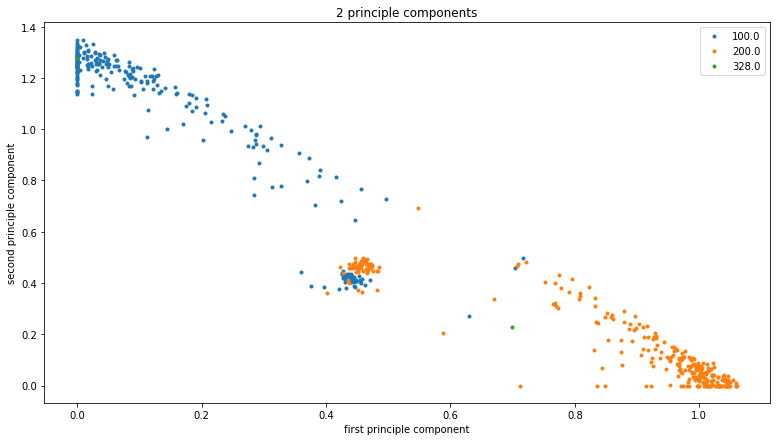

In [ ]:
plot_nmf(W, oneohsix_parties)

[[1.10700702 0.98930767 0.         ... 0.82993503 0.82887204 0.62326878]
 [0.01439423 0.         0.80990835 ... 0.67923324 0.51828925 0.67428398]]


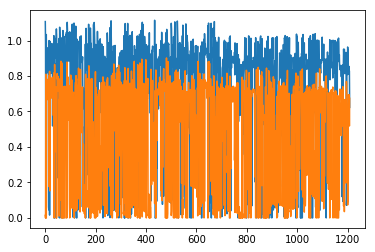

In [ ]:
print(H)
plt.plot(H[0], label = 'first principle component')
plt.plot(H[1], label = 'second principle component')

## even with the nonNegative matrix factorization, we still have the third cluster, which is very interesting. 

# make a function to do the above for any given congress

In [ ]:
def PCA_Plotting(n = 116):
    #isolate the votes from this specific congress
    nth_congress = mem_votes.loc[mem_votes.congress == n]
    nth_congress = nth_congress[['congress', 'rollnumber', 'icpsr', 'yea_nay']]
    
    #find the number of congresspeople and bills and so on
    bills = len(nth_congress['rollnumber'].unique())
    rollcalls = list(nth_congress['rollnumber'].unique())
    congresspeople = len(nth_congress['icpsr'].unique())
    icpsrs = list(nth_congress['icpsr'].unique())
    nth_votes = np.zeros((congresspeople, bills))

    #make a matrix out of the votes
    for index, row in nth_congress.iterrows():
        nth_votes[icpsrs.index(row['icpsr'])][rollcalls.index(row['rollnumber'])] = row['yea_nay']

    #find the party lables for the congresspeople
    nth_parties = np.zeros(congresspeople)
    for i, icp in enumerate(icpsrs):
        nth_parties[i] = idea.loc[idea.icpsr == icp].sample(1).party_code
    
    #using the methods I coded up do the PCA
    plot_scree(nth_votes)
    projected_votes = plot2(nth_votes, nth_parties)

    #using the sklearn version, do the same thing but with nonnegative matrix factorization
    W, H = nonnegative_components(nth_votes)
    
    
    plot_nmf(W, nth_parties)


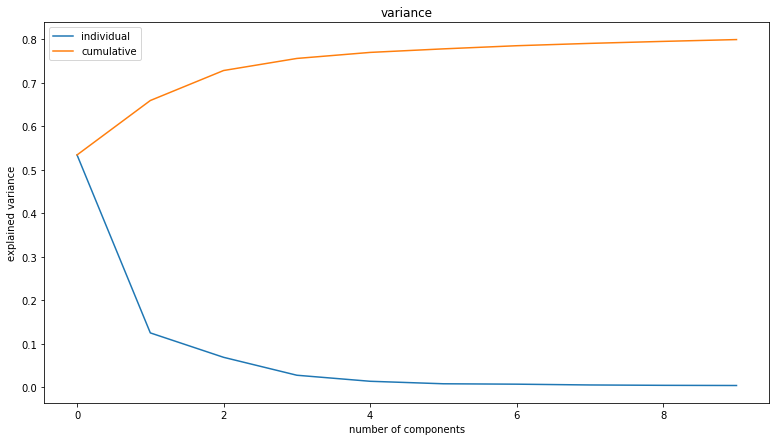

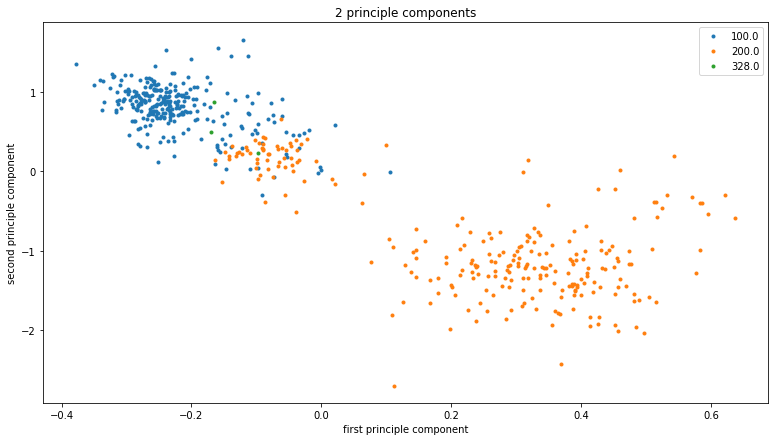

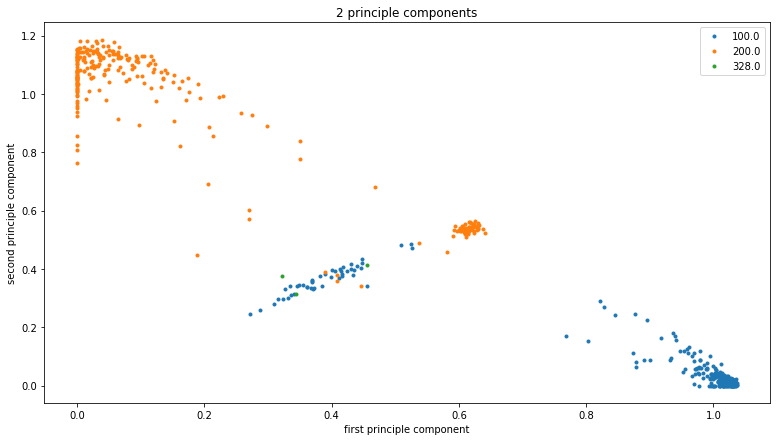

In [ ]:
PCA_Plotting(116)

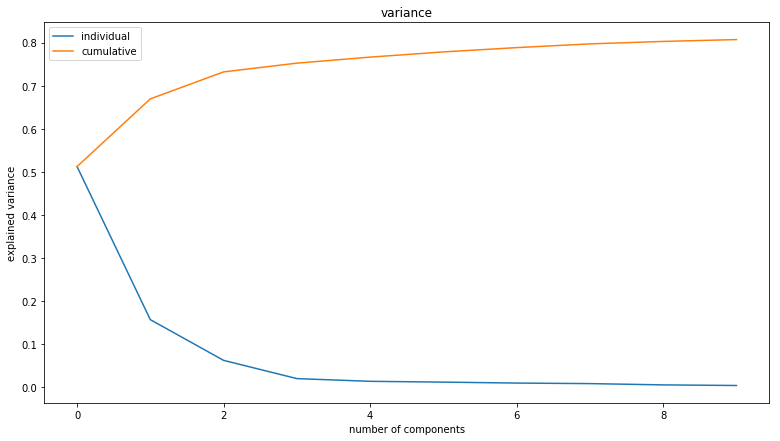

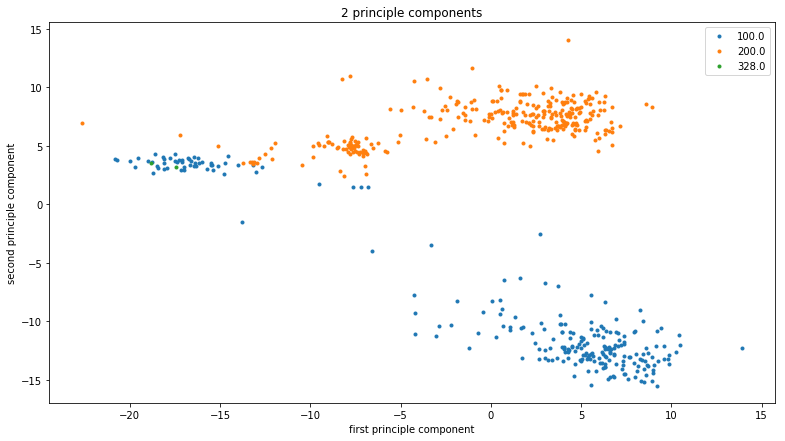

(556, 2)


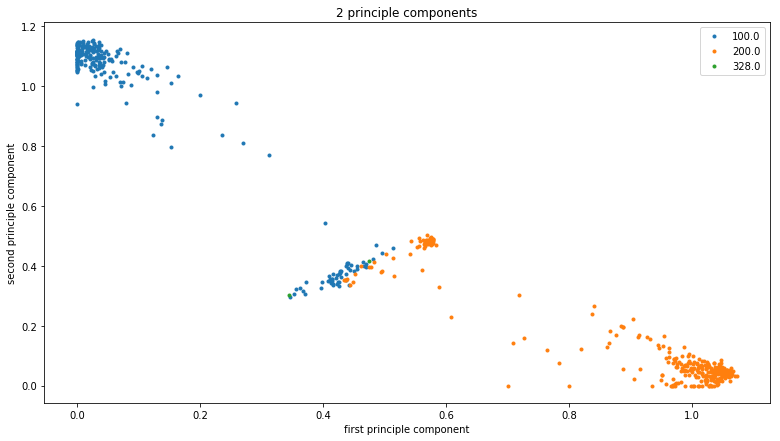

In [ ]:
PCA_Plotting(115)

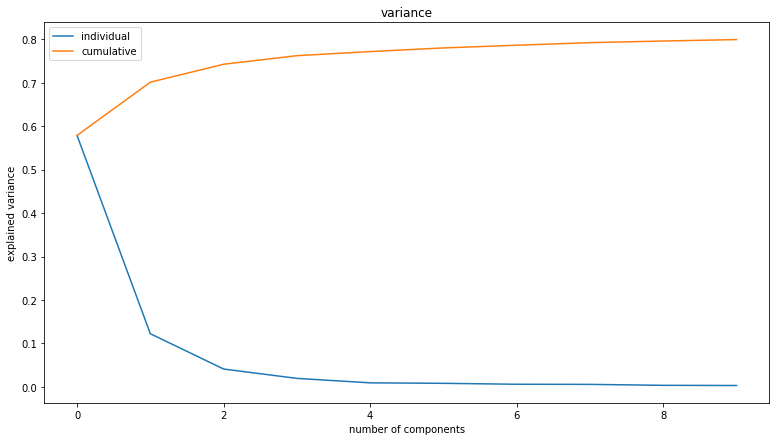

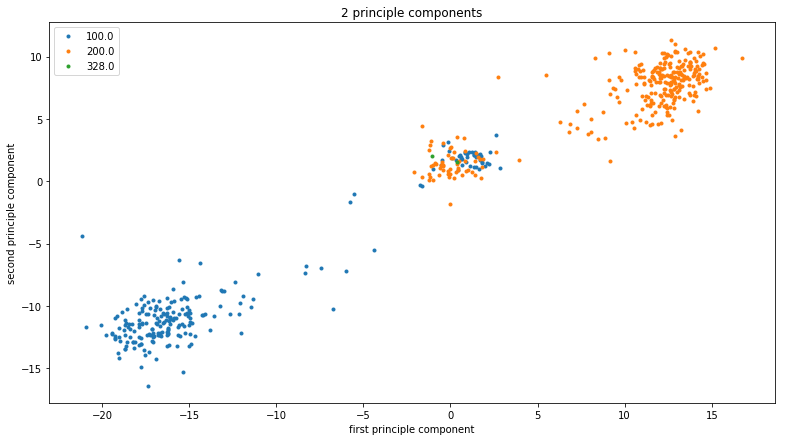

(541, 2)


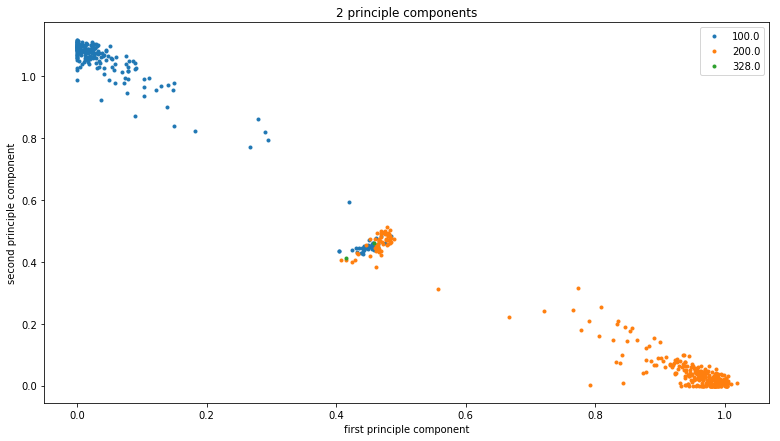

In [ ]:
PCA_Plotting(114)

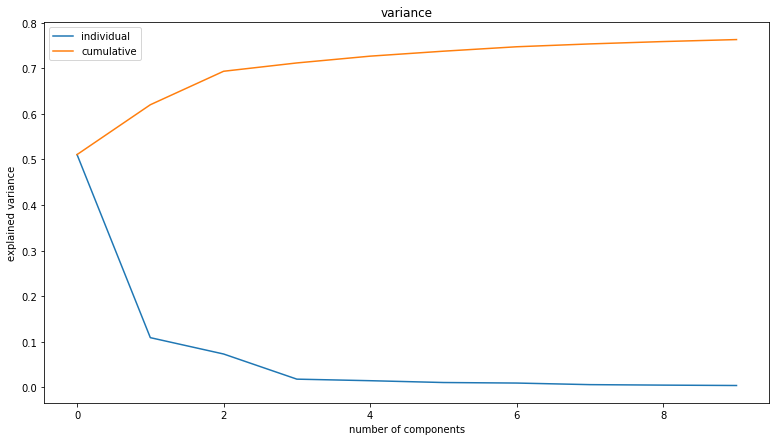

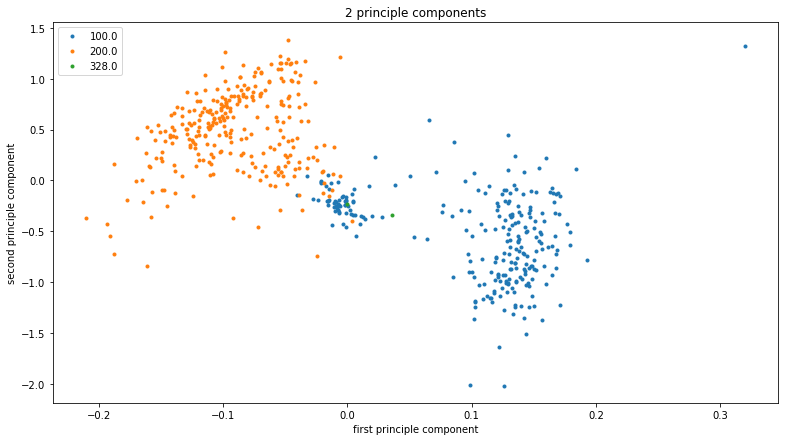

(549, 2)


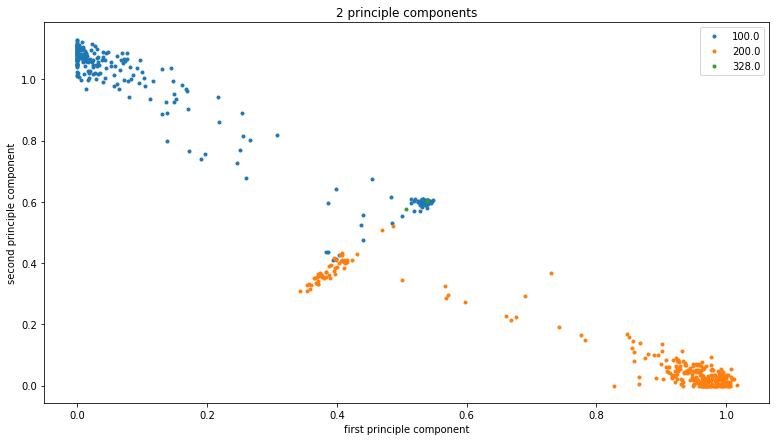

In [ ]:
PCA_Plotting(113)

# Now we're doing clustering at the same time

In [ ]:
import numpy as np
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans as kmeans
from sklearn.neighbors import kneighbors_graph
import scipy.linalg as la

In [ ]:
def spectral_cluster(X):
    A = kneighbors_graph(X, 5).toarray()
    A = A + A.T - A*A.T
    D = np.sum(A, axis = 1)
    # print(D)
    L = np.diag(D) - A
    
    eigvals, eigs= la.eigh(L)
#     plt.plot(eigvals)
    # print(eigs[1])
#     print(np.sum(eigvals <= .0001))
    
    d = np.diag(D**(-1/2))
    DLD = d @ L @ d
    eigvals, eigs= la.eigh(DLD)
    
    Jp = []
    Jm = []
    for i, v in enumerate(eigs[:,1]):
        if v >0:
            Jp.append(i)
        else:
            Jm.append(i)
    
    plt.figure(figsize = (13,7))
    plt.plot(X[Jp][:,0], X[Jp][:,1], '.')
    plt.plot(X[Jm][:,0], X[Jm][:,1], '.')
    plt.title("Spectral Clustering")
    plt.show()
    
    
def spec(X):
    A = kneighbors_graph(X, 5).toarray()
    A = A + A.T - A*A.T
    D = np.sum(A, axis = 1)
    # print(D)
    L = np.diag(D) - A
    
    eigvals, eigs= la.eigh(L)
#     plt.plot(eigvals)
    # print(eigs[1])
#     print(np.sum(eigvals <= .0001))
    
    d = np.diag(D**(-1/2))
    DLD = d @ L @ d
    eigvals, eigs= la.eigh(DLD)
    
    Jp = []
    Jm = []
    for i, v in enumerate(eigs[:,1]):
        if v >0:
            Jp.append(i)
        else:
            Jm.append(i)
    
    return(X[Jp],X[Jm])
        
    
    
    
def spectral_cluster3(X):
    X1, X2 = spec(X)
    if X2.size > 0:
        X2, X3 = spec(X2)
        plt.figure(figsize = (13,7))
        plt.plot(X1[:,0], X1[:,1], '.')
        plt.plot(X2[:,0], X2[:,1], '.')
        plt.plot(X3[:,0], X3[:,1], '.')
    else:
        plt.figure(figsize = (13,7))
        plt.plot(X1[:,0], X1[:,1], '.')
        plt.plot(X2[:,0], X2[:,1], '.')
    
    plt.title("Spectral Clustering")
    plt.show()
    
    

In [ ]:
def kmeans_cluster(X):
    km = kmeans(3)
    y = km.fit(X).labels_
    plt.figure(figsize = (13,7))
    for i in np.unique(y):
        x = X[y==i]
        plt.plot(x[:,0], x[:,1], '.')
    plt.title("Kmeans clustering")
    plt.show()

In [ ]:
def PCA_Plotting_clustering(n = 116):
    #isolate the votes from this specific congress
    nth_congress = mem_votes.loc[mem_votes.congress == n]
    nth_congress = nth_congress[['congress', 'rollnumber', 'icpsr', 'yea_nay']]
    
    #find the number of congresspeople and bills and so on
    bills = len(nth_congress['rollnumber'].unique())
    rollcalls = list(nth_congress['rollnumber'].unique())
    congresspeople = len(nth_congress['icpsr'].unique())
    icpsrs = list(nth_congress['icpsr'].unique())
    nth_votes = np.zeros((congresspeople, bills))

    #make a matrix out of the votes
    for index, row in nth_congress.iterrows():
        nth_votes[icpsrs.index(row['icpsr'])][rollcalls.index(row['rollnumber'])] = row['yea_nay']

    #find the party lables for the congresspeople
    nth_parties = np.zeros(congresspeople)
    for i, icp in enumerate(icpsrs):
        nth_parties[i] = idea.loc[idea.icpsr == icp].sample(1).party_code
    
    #using the methods I coded up do the PCA
    plot_scree(nth_votes)
    projected_votes = plot2(nth_votes, nth_parties)
    #show the clustered version
    spectral_cluster3(projected_votes)
    kmeans_cluster(projected_votes)

    #using the sklearn version, do the same thing but with nonnegative matrix factorization
    W, H = nonnegative_components(nth_votes)
    
    plot_nmf(W, nth_parties)
    #show the clustered version
    spectral_cluster3(W)
    kmeans_cluster(W)

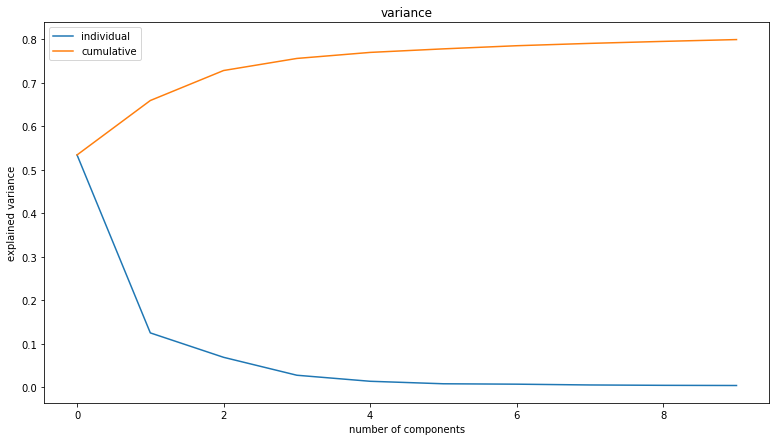

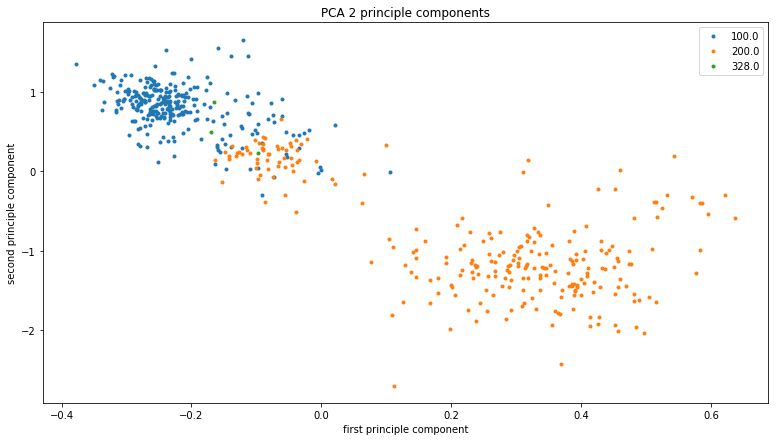

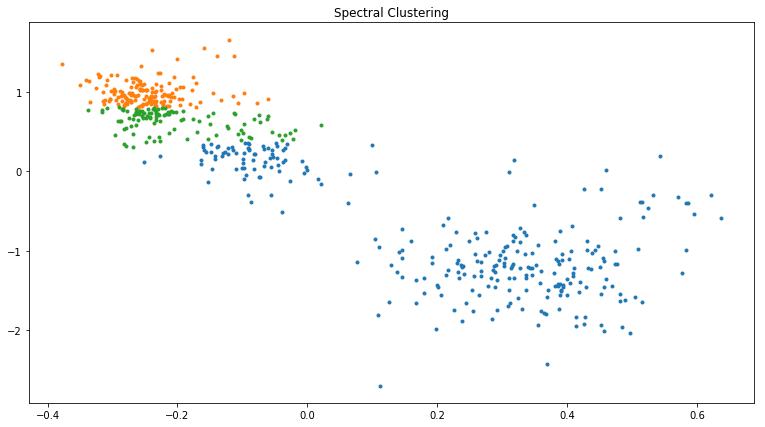

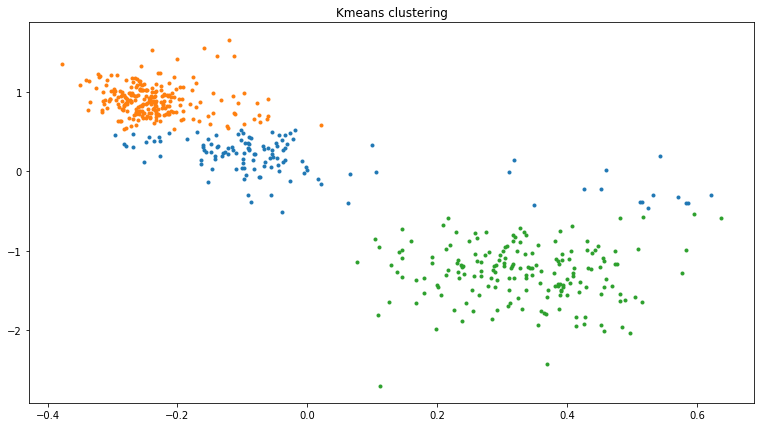

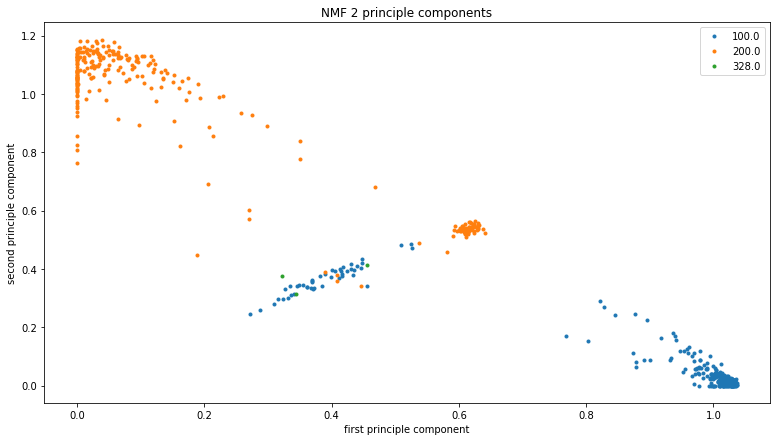

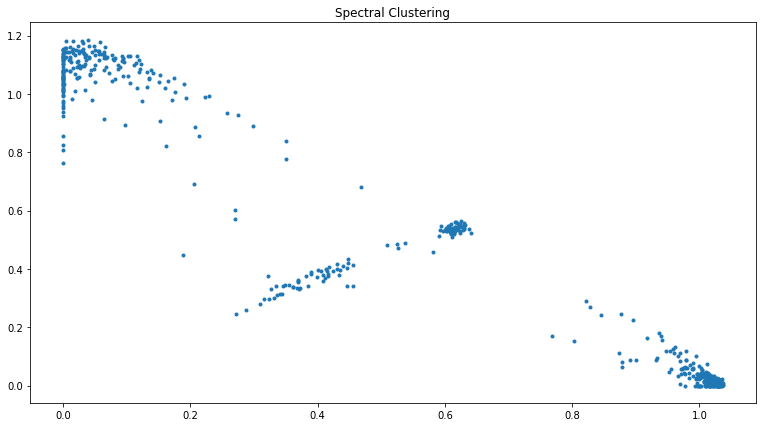

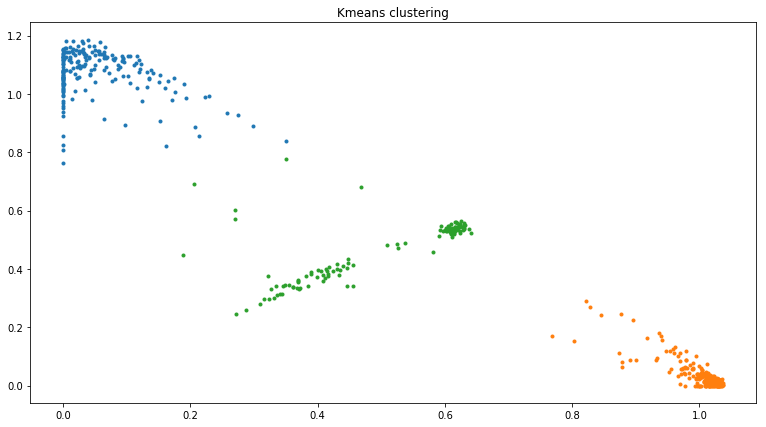

In [ ]:
PCA_Plotting_clustering()

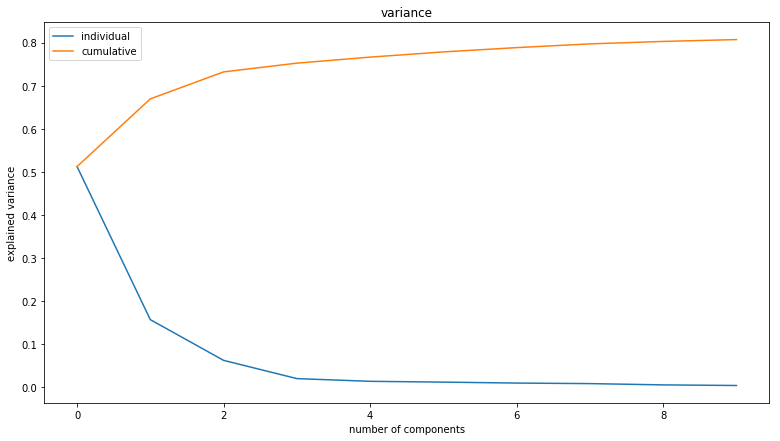

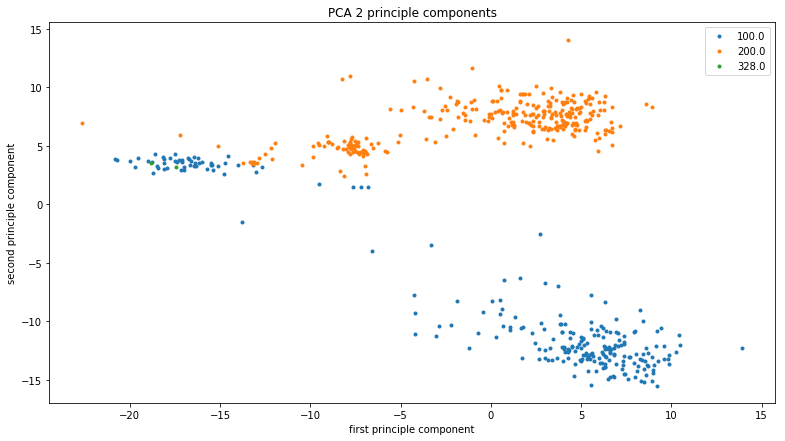

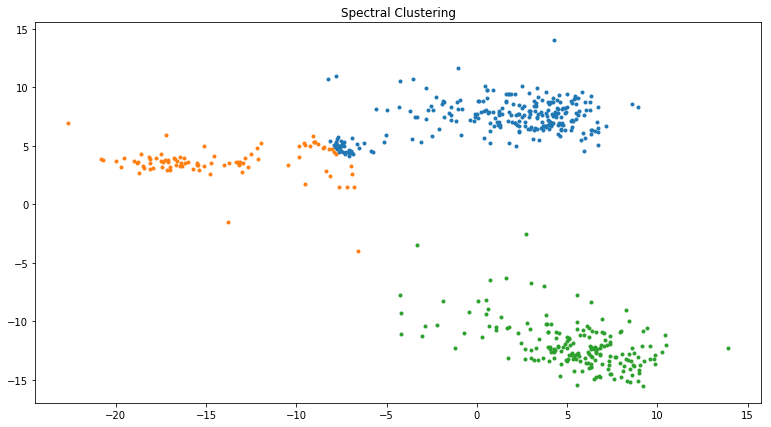

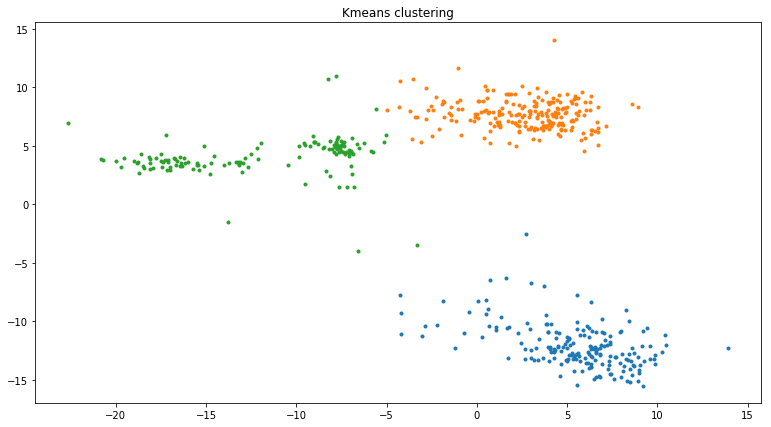

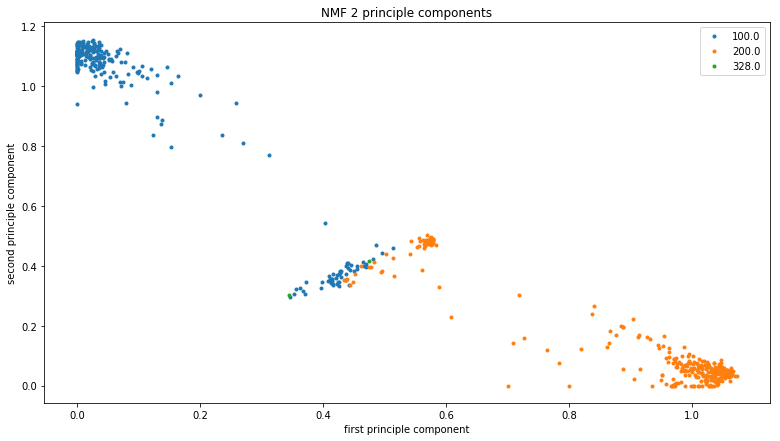

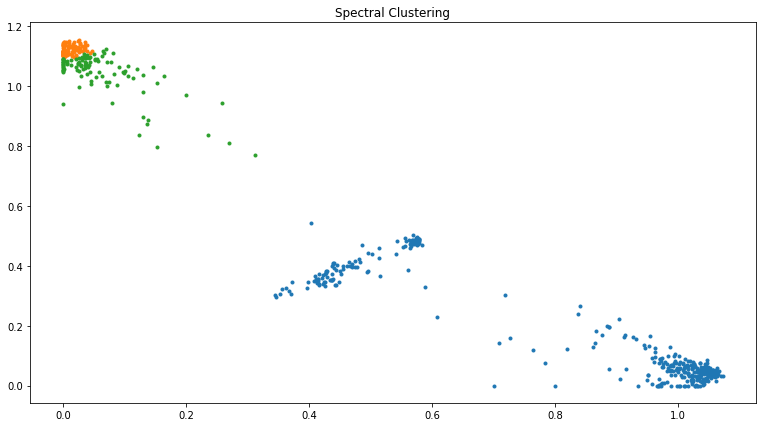

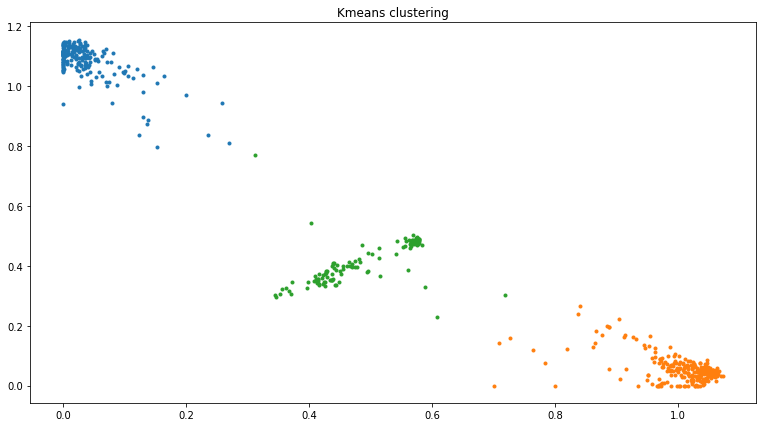

In [ ]:
PCA_Plotting_clustering(115)

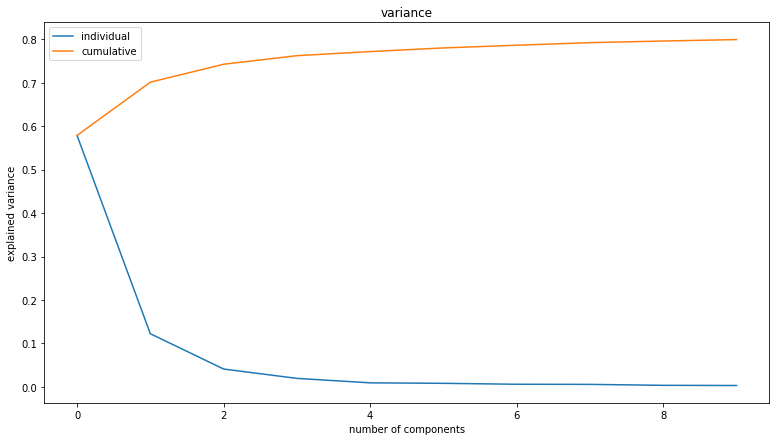

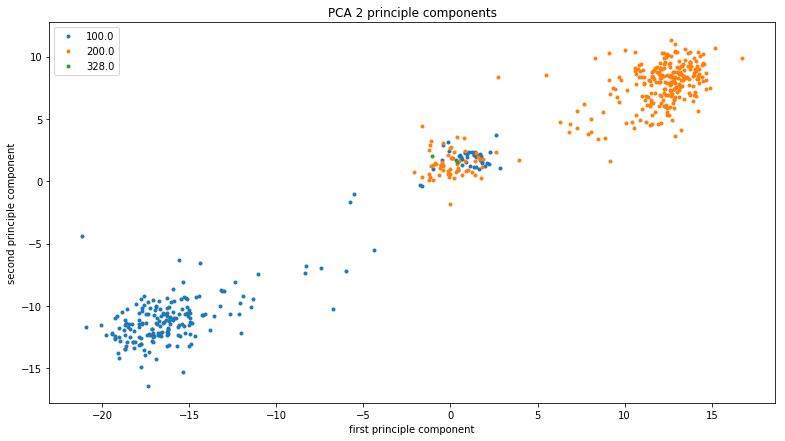

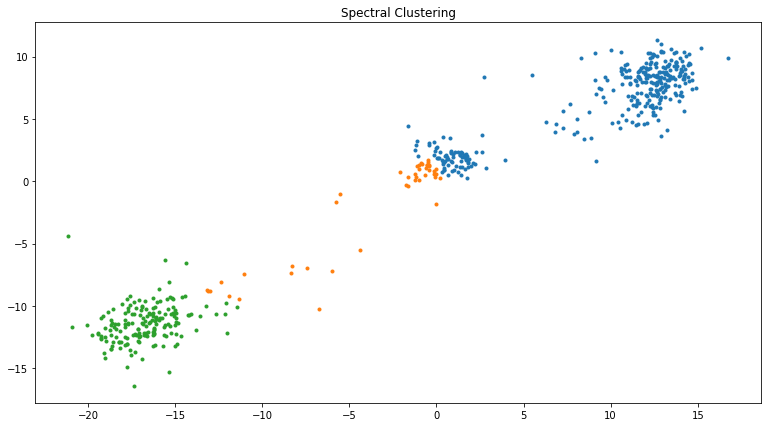

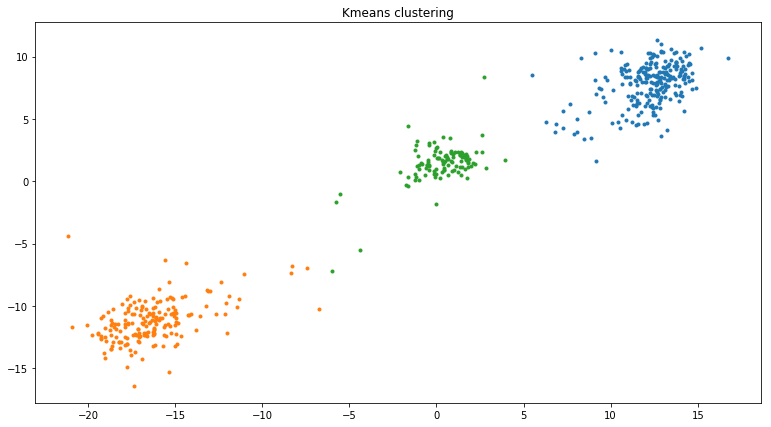

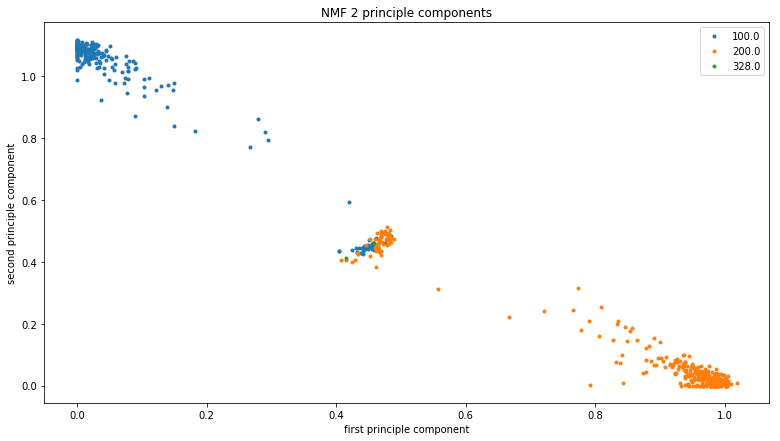

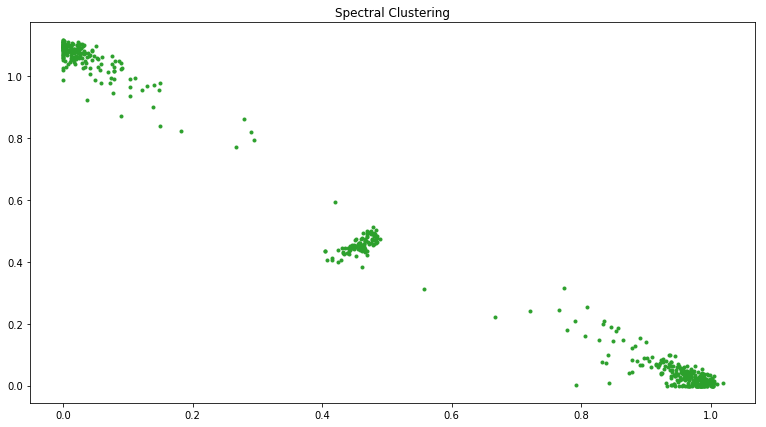

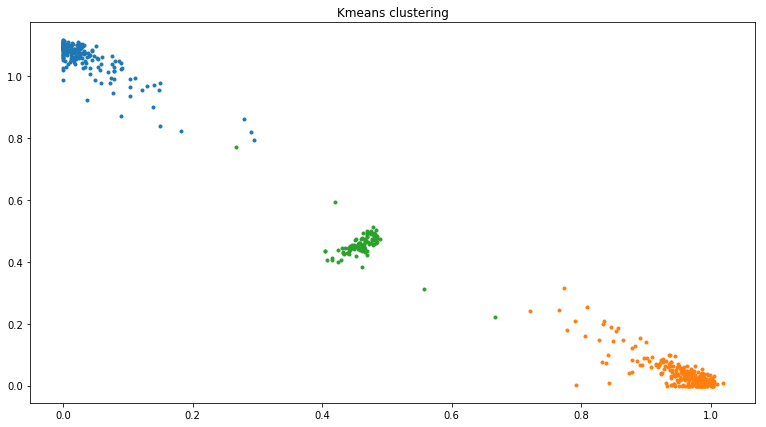

In [ ]:
PCA_Plotting_clustering(114)

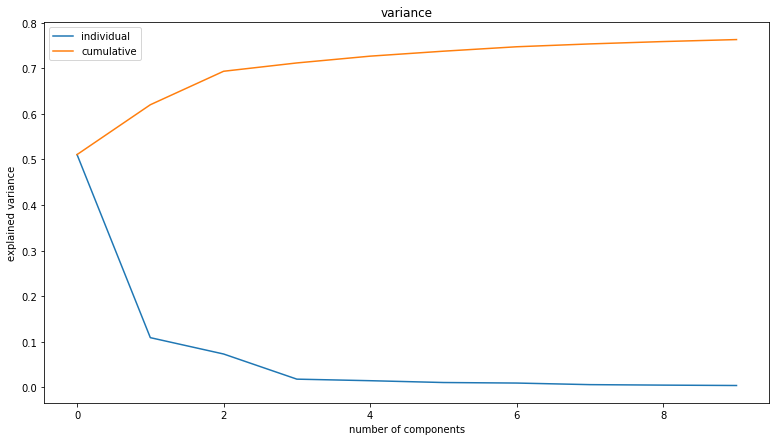

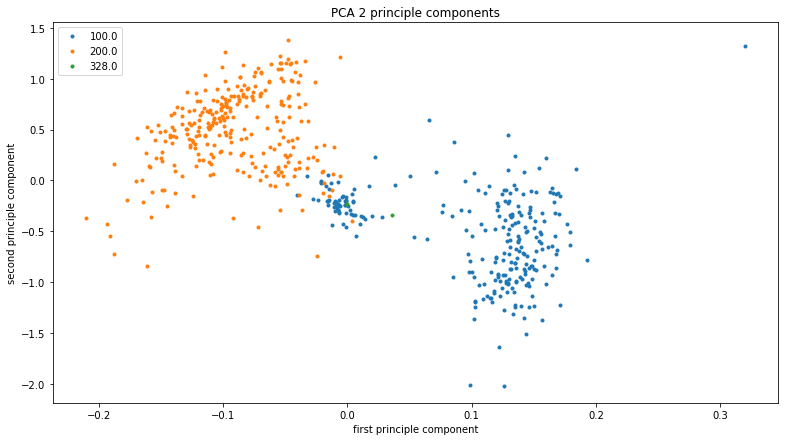

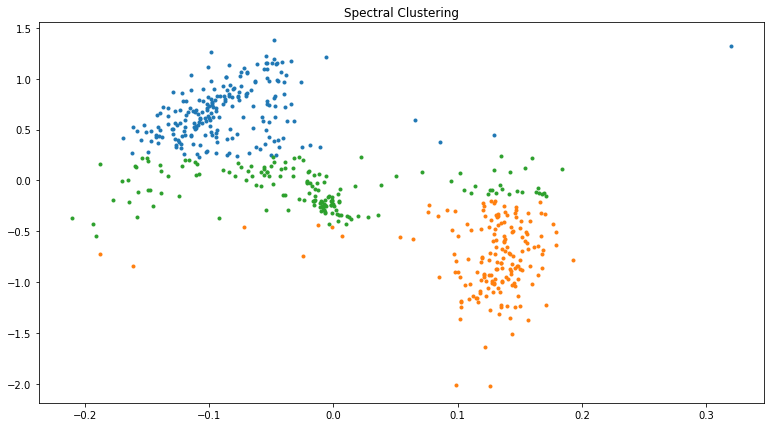

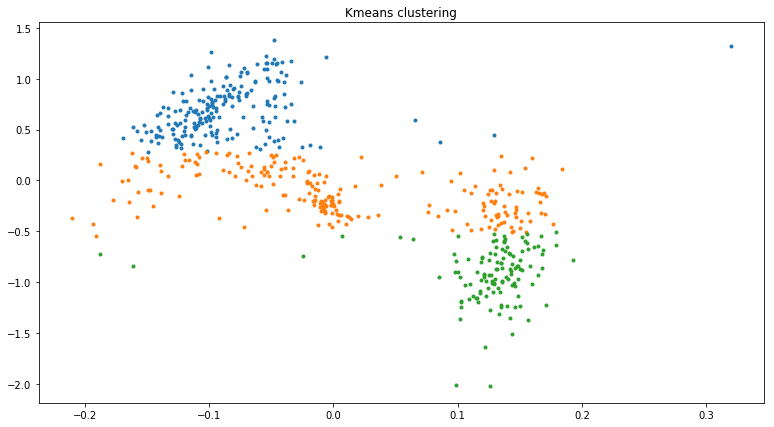

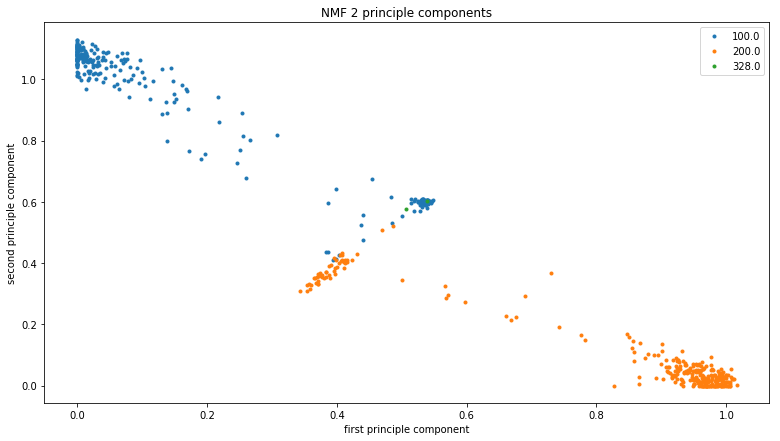

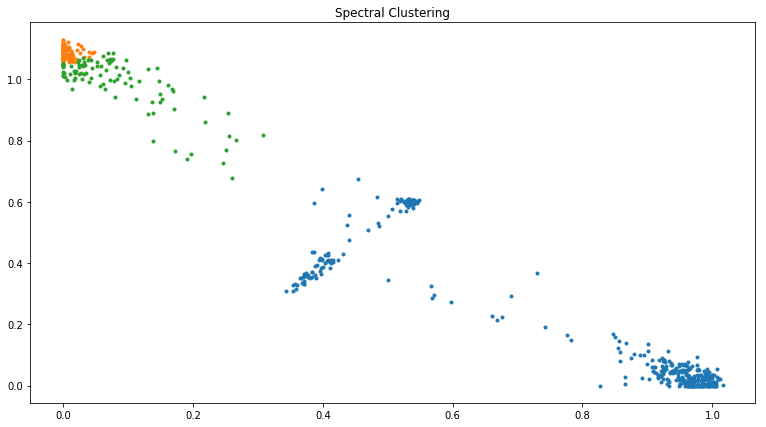

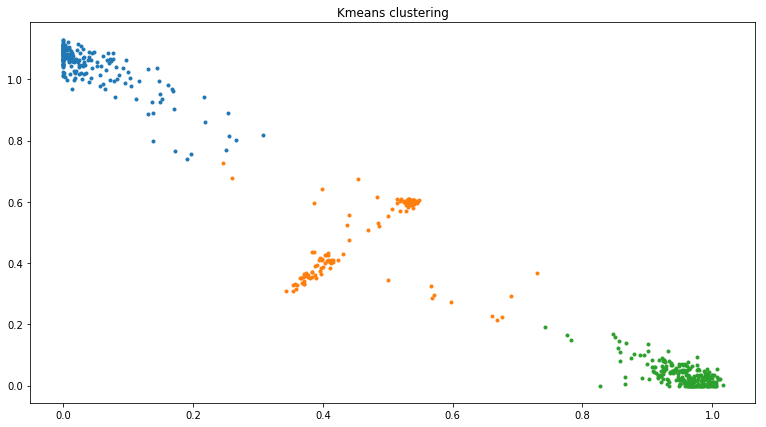

In [ ]:
PCA_Plotting_clustering(113)

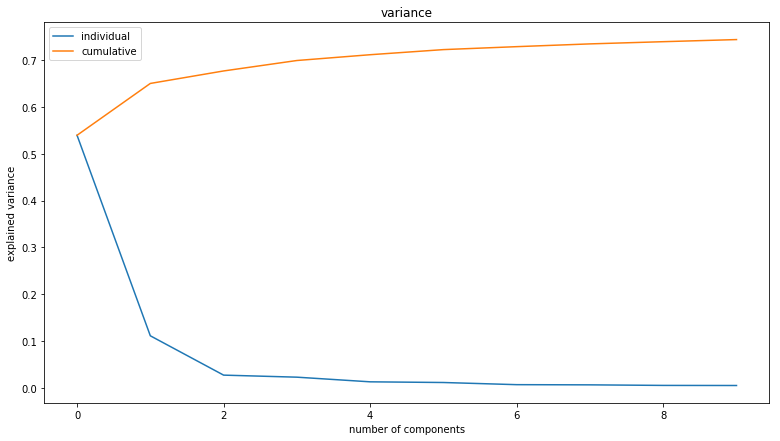

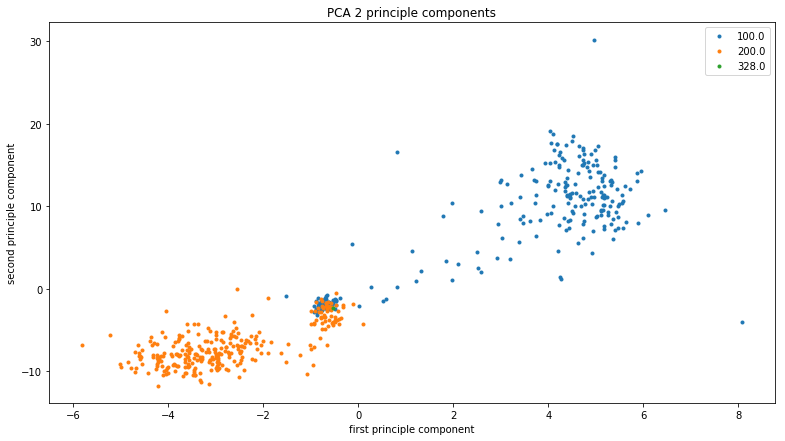

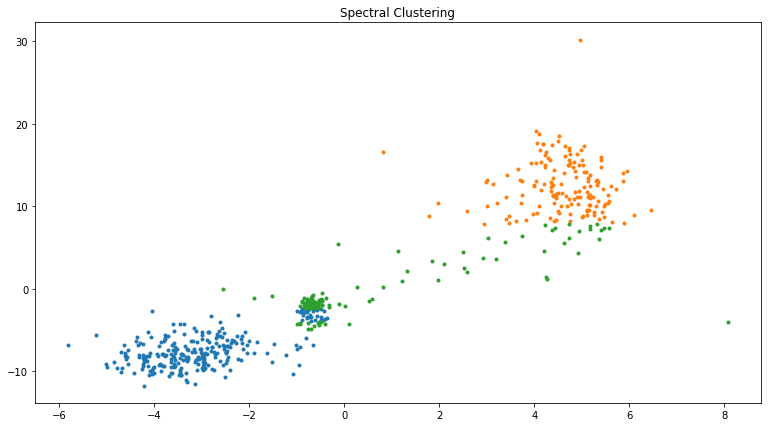

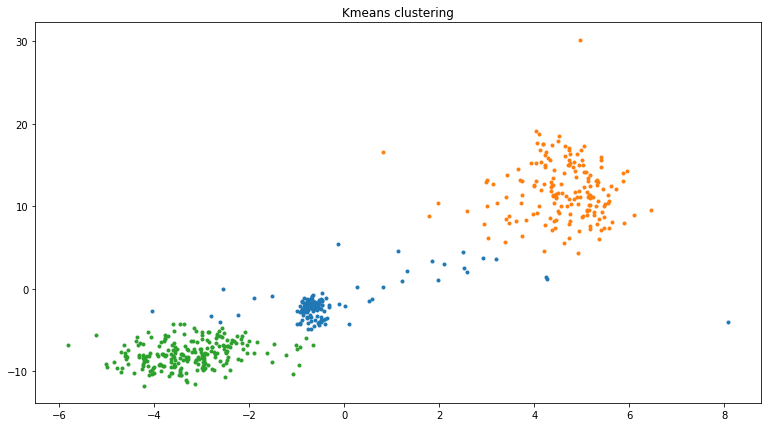

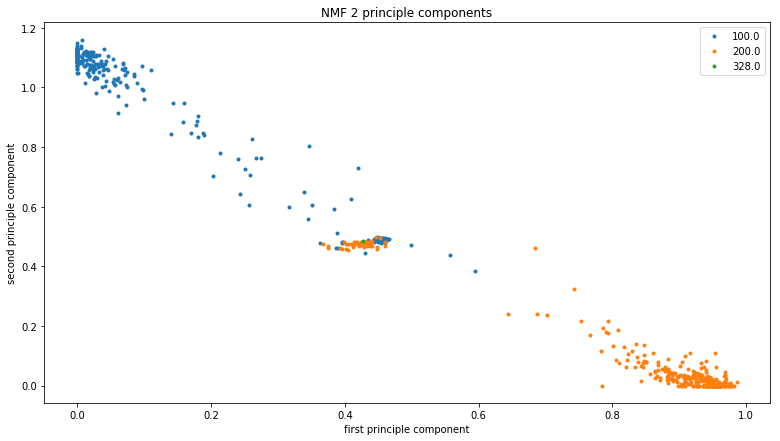

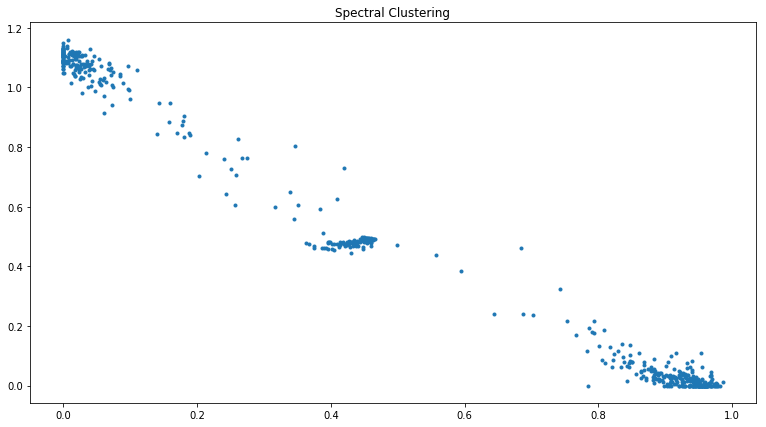

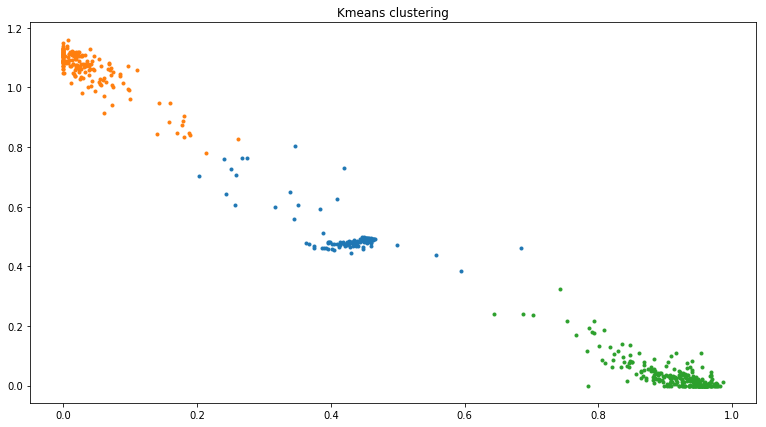

In [ ]:
PCA_Plotting_clustering(112)